## Compare Experiments

In [1]:
import json
from glob import glob
import pandas as pd
import json

from pprint import pprint

from app.artifactory import LocalArtifactory
from app.plotting import learning_curve_subplot
import matplotlib.pyplot as plt

In [2]:
experiments_uri = "../storage/experiments/"

In [3]:
experiment_dirs = sorted(glob(f"{experiments_uri}/*"))

In [4]:
experiments_map = {eid: d.split("/")[-1] for eid, d in enumerate(experiment_dirs)}

In [5]:
mp = lambda eid: experiments_map[eid]

In [6]:
af = lambda eid: [LocalArtifactory(uri=dir) for dir in glob(f"{experiments_uri}/{mp(eid)}/*")]

##### Past experiment runs

In [7]:
# key is experiment id (eid)
experiments_map

{0: '2023-12-03 22:50:49.726455'}

#### These are the tags and configuration of a past experiment

In [8]:
eid=0
[ art.load("tags") for art in af(eid)]

[{'name': 'best-model', 'timestamp': '2023-12-03 22:50:49.733678'},
 {'name': 'default', 'timestamp': '2023-12-03 22:50:49.733888'}]

In [9]:
[(art.load("tags"), json.loads(art.load("conf"))) for art in af(eid)]

[({'name': 'best-model', 'timestamp': '2023-12-03 22:50:49.733678'},
  {'seed': 999.0,
   'feature_names': ['query'],
   'target_feature': 'target',
   'train_data_path': 'storage/data/atis/train.tsv',
   'test_data_path': 'storage/data/atis/test.tsv',
   'train_test_split': 0.7,
   'load_data_csv_seperator': '\t',
   'tune_model': False,
   'max_sequence_length': 10,
   'tokenizer_class': 'KerasTokenizer',
   'stopwords_languages': ['english'],
   'embedings_file_path': 'storage/embedings/glove.6B.50d.txt',
   'training_module': 'app.models.cnn',
   'builder_class': 'KerasConvolutionalBuilder',
   'builder_input_specs': [{'filters': 8,
     'kernel_size': 4,
     'activation': 'selu'},
    {'pool_size': 2}],
   'builder_output_specs': None,
   'builder_optimizer_specs': {'name': 'Adam', 'learning_rate': 0.0001},
   'builder_loss_specs': {'name': 'CategoricalCrossentropy'},
   'final_activation': 'softmax',
   'train_embedings': False,
   'epochs': 20,
   'batch_size': 128,
   'use_wei

#### Train and Test learning for the Principal Model

{'batch_size': 128,
 'builder_class': 'KerasConvolutionalBuilder',
 'builder_input_specs': [{'activation': 'selu', 'filters': 8, 'kernel_size': 4},
                         {'pool_size': 2}],
 'builder_loss_specs': {'name': 'CategoricalCrossentropy'},
 'builder_optimizer_specs': {'learning_rate': 0.0001, 'name': 'Adam'},
 'builder_output_specs': None,
 'embedings_file_path': 'storage/embedings/glove.6B.50d.txt',
 'epochs': 20,
 'feature_names': ['query'],
 'final_activation': 'softmax',
 'load_data_csv_seperator': '\t',
 'max_sequence_length': 10,
 'seed': 999.0,
 'stopwords_languages': ['english'],
 'target_feature': 'target',
 'test_data_path': 'storage/data/atis/test.tsv',
 'tokenizer_class': 'KerasTokenizer',
 'train_data_path': 'storage/data/atis/train.tsv',
 'train_embedings': False,
 'train_test_split': 0.7,
 'training_module': 'app.models.cnn',
 'tune_model': False,
 'use_muse': False,
 'use_tensorboard': False,
 'use_tf_idf': False,
 'use_weights': False}


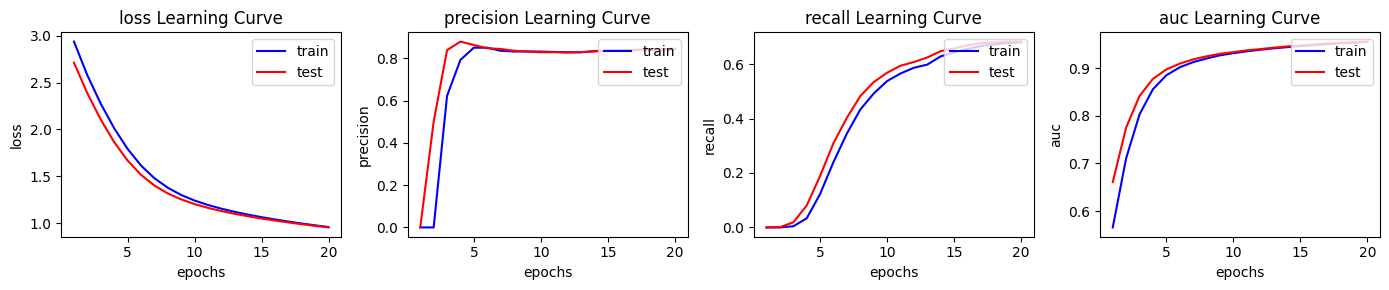

In [48]:
#TODO: make a function for this
pa = LocalArtifactory(uri="../storage/artifactory/principal-model")
train_metrics = pa.load("train_metrics")
test_metrics = pa.load("test_metrics")

fig, axes = plt.subplots(1,4, figsize=(14,3))
metric_names = pa.load("metric_names")
for idx, (ax, name) in enumerate(zip(axes, metric_names)):
    train_lc = list(map(lambda x: x[idx+1], train_metrics))
    test_lc = list(map(lambda x: x[idx+1], test_metrics))
    learning_curve_subplot(ax=ax, train_lc=train_lc, test_lc=test_lc, metric_name=name)
    fig.tight_layout()
pprint(json.loads(pa.load("conf")))

#### Compare two models in an experiments

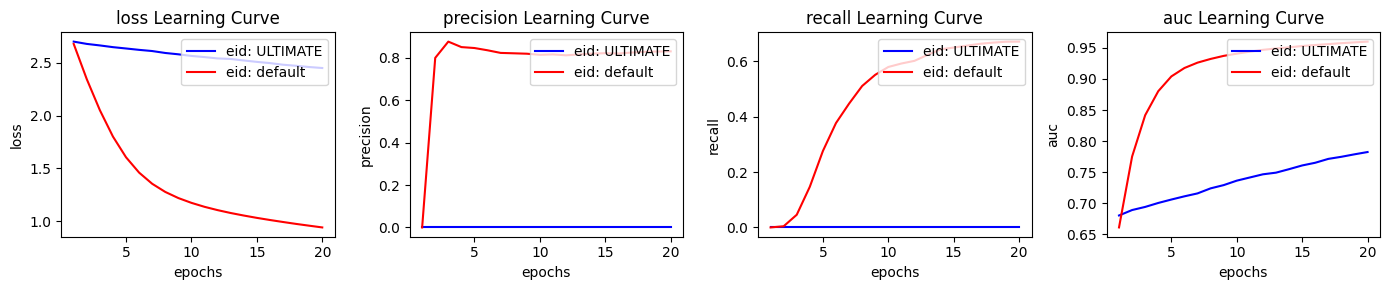

In [93]:
eid = 8

names = af(eid)[0].load("metric_names")
tags = (af(eid)[0].load("tags")["name"], af(eid)[1].load("tags")["name"])
fig, axes = plt.subplots(1,4, figsize=(14,3))
for idx, (ax, name) in enumerate(zip(axes, names)):
    lc1 = list(map(lambda x: x[idx+1], af(eid)[0].load("test_metrics")))
    lc2 = list(map(lambda x: x[idx+1], af(eid)[1].load("test_metrics")))
    learning_curve_subplot(ax=ax, train_lc=lc1, test_lc=lc2, metric_name=name, train_name=f"eid: {tags[0]}", test_name=f"eid: {tags[1]}")
    fig.tight_layout()


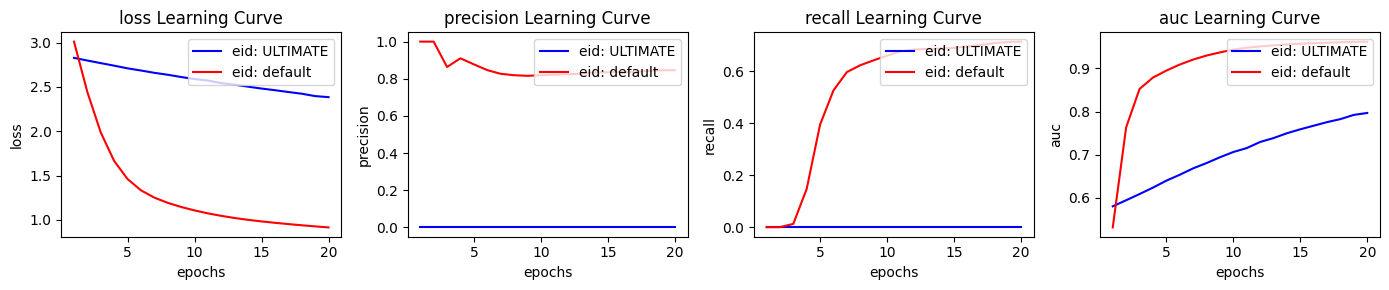

In [10]:
eid = 0

names = af(eid)[0].load("metric_names")
tags = (af(eid)[0].load("tags")["name"], af(eid)[1].load("tags")["name"])
fig, axes = plt.subplots(1,4, figsize=(14,3))
for idx, (ax, name) in enumerate(zip(axes, names)):
    lc1 = list(map(lambda x: x[idx+1], af(eid)[0].load("test_metrics")))
    lc2 = list(map(lambda x: x[idx+1], af(eid)[1].load("test_metrics")))
    learning_curve_subplot(ax=ax, train_lc=lc1, test_lc=lc2, metric_name=name, train_name=f"eid: {tags[0]}", test_name=f"eid: {tags[1]}")
    fig.tight_layout()


#### Quick exploration of the embeded space

I wanted to explore the representation of the queries on the embedings space.
For the query embeding I am adding the word embedings as vectors. Probably a very naive assumption...

I assumed that quaries that are labeled the same have their endpoint close in the embeded space.

I also did a keans clustering to see if there is any structure in the manifold regardless of how we label the data externally.

In [67]:
pa = LocalArtifactory(uri="../storage/artifactory/principal-model")

In [68]:
pa.list_artifacts()

['metric_names',
 'preprocessor',
 'test_metrics',
 'tokenizer',
 'label_encoder',
 'embeddings_matrix',
 'model',
 'conf',
 'train_metrics',
 'tags',
 'x_train_tokenized',
 'x_test_processed',
 'weights',
 'labels_test',
 'labels_train',
 'x_test_tokenized',
 'word_index',
 'serving_model',
 'x_train_processed']

In [73]:
em = pa.load("embeddings_matrix")
wi = pa.load("word_index")
x_train_tokenized = pa.load("x_train_tokenized")
labels = pa.load("labels_train")
la_encoder = pa.load("label_encoder")
sm = pa.load("serving_model")
conf = pa.load("conf")

In [72]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.manifold import TSNE
import seaborn as sns
from app.load_data import read_and_reshuffle_data

In [12]:
x_embeded = list(map(lambda d:[em[t] for t in d], x_train_tokenized))
x_embeded = np.array(x_embeded).sum(axis=1)

In [44]:
map_inv = {v:k for k,v in la_encoder.mapping.items()}
map_inv

{0: 'distance',
 1: 'flight',
 2: 'airfare',
 3: 'airport',
 4: 'capacity',
 5: 'city',
 6: 'cheapest',
 7: 'flight_time',
 8: 'aircraft',
 9: 'meal',
 10: 'quantity',
 11: 'ground_fare',
 12: 'airline',
 13: 'restriction',
 14: 'ground_service',
 15: 'abbreviation',
 16: 'flight_no'}

In [49]:
pca = PCA(n_components=0.80, random_state=42) #Keep 95% of the variance
x_reduced= pca.fit_transform(x_embeded)
x_reduced.shape

(6485, 10)

In [50]:
pca.explained_variance_

array([59.24841754, 12.93721356, 10.25026462,  7.35357027,  6.20089169,
        5.30304586,  4.3546864 ,  3.9186553 ,  3.2519612 ,  3.06170852])

In [51]:
k = la_encoder.max_dim
kmeans = KMeans(n_clusters=n_categories, random_state=42)
y_kmeans = kmeans.fit_predict(x_reduced)

/home/vsyropou/workdir/ultimate/ultimate-challenge/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [52]:
la_encoder.max_dim

17

In [25]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
x_tsne_embedded = tsne.fit_transform(x_embeded)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6485 samples in 0.003s...
[t-SNE] Computed neighbors for 6485 samples in 0.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6485
[t-SNE] Computed conditional probabilities for sample 2000 / 6485
[t-SNE] Computed conditional probabilities for sample 3000 / 6485
[t-SNE] Computed conditional probabilities for sample 4000 / 6485
[t-SNE] Computed conditional probabilities for sample 5000 / 6485
[t-SNE] Computed conditional probabilities for sample 6000 / 6485
[t-SNE] Computed conditional probabilities for sample 6485 / 6485
[t-SNE] Mean sigma: 3.761233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.895187
[t-SNE] KL divergence after 1000 iterations: 1.172596


/tmp/ipykernel_87533/3623798190.py:5: UserWarning: The palette list has more values (20) than needed (17), which may not be intended.
  sns.scatterplot(x=x_tsne_embedded[:,0], y=x_tsne_embedded[:,1], hue=y_kmeans, legend='full', palette=palette)


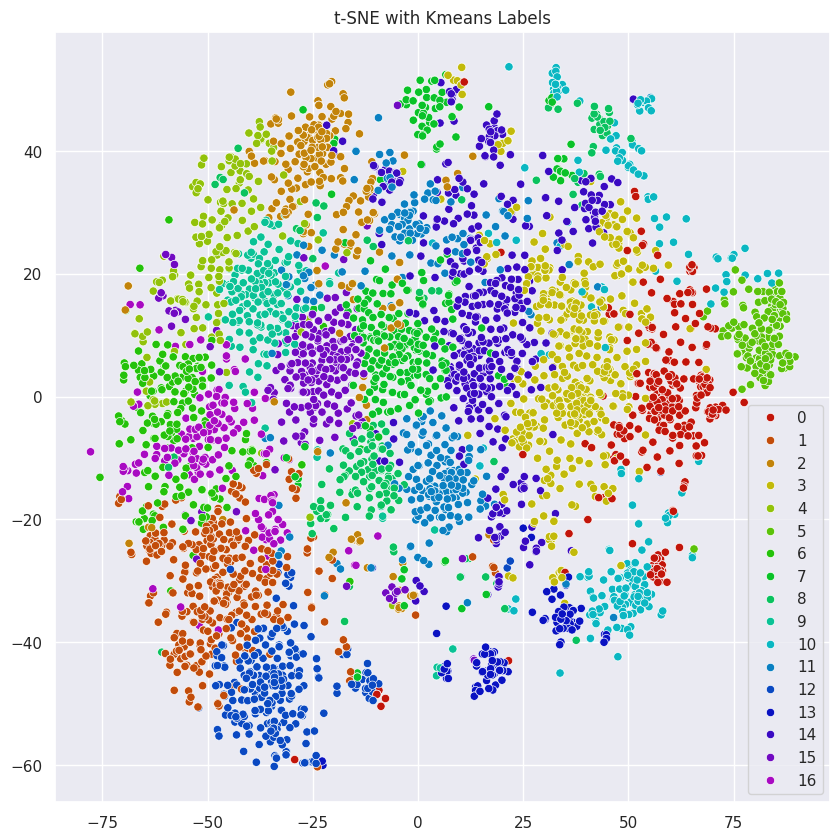

In [93]:
#%matplotlib inline
sns.set(rc={'figure.figsize':(10, 10)})
palette = sns.hls_palette(20, l=.4, s=.9)

sns.scatterplot(x=x_tsne_embedded[:,0], y=x_tsne_embedded[:,1], hue=y_kmeans, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("../images/tsne_kmeans.pdf")
plt.show()

There are some clear clusters that the k means could find
The question how do they compare to the true labels 

/tmp/ipykernel_87533/221982437.py:4: UserWarning: The palette list has more values (20) than needed (17), which may not be intended.
  sns.scatterplot(x=x_tsne_embedded[:,0], y=x_tsne_embedded[:,1], hue=list(map(lambda l: map_inv[l.argmax()], labels)), legend='full', palette=palette)


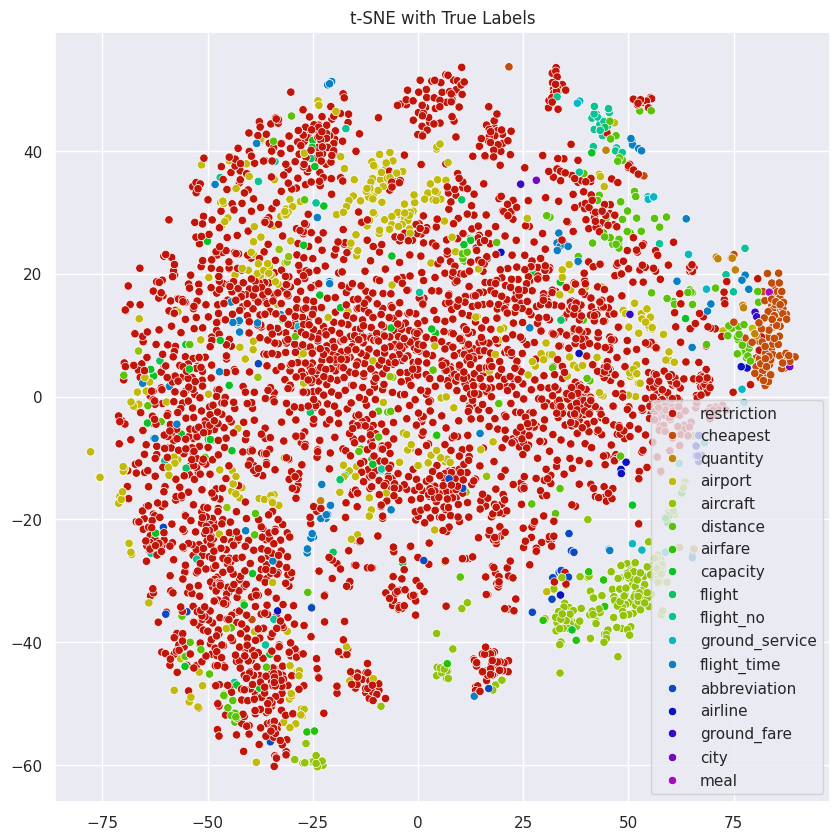

In [94]:
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(20, l=.4, s=.9)

sns.scatterplot(x=x_tsne_embedded[:,0], y=x_tsne_embedded[:,1], hue=list(map(lambda l: map_inv[l.argmax()], labels)), legend='full', palette=palette)
plt.title('t-SNE with True Labels')
plt.savefig("../images/tsne_true_labels.pdf")
plt.show()

Here we see the majority of the labels are actually fliaght
They are so many that they practivcally do not much information.
The interasteing categories are the abbreviationand ground_service for which Kmeans also seem to have foudn structure in this area

Now let's what did the model prected